In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

In [2]:
def set_seed():
    np.random.seed(20020703)

In [3]:
def simulate_bachelier(T, n_steps, X0, sigma):
    """
    Simulate Bachelier model using Euler-Maruyama method
    T: Time horizon
    n_steps: Number of time steps
    F0: Initial forward price
    sigma_N: volatility
    """
    dt = T / n_steps
    t = np.linspace(0, T, n_steps)
    dW = np.random.normal(0, np.sqrt(dt), n_steps)
    X = np.zeros(n_steps)
    X[0] = X0

    for i in range(1, n_steps):
        X[i] = X[i-1] + sigma * dW[i-1]
    
    return t, X

In [4]:
def simulate_observed_price(X, alpha, eta, L=1):
    
    P = np.zeros_like(X)
    P[0] = np.round(X[0] / alpha) * alpha
    change_indices = [0]

    for i in range(1, len(X)):
        # 使用第一版的阈值计算方式
        upper_threshold = P[i-1] + alpha * (L - 0.5 + eta)
        lower_threshold = P[i-1] - alpha * (L - 0.5 + eta)
        
        # 直接比较有效价格与阈值
        if X[i] >= upper_threshold:
            P[i] = P[i-1] + L * alpha
            change_indices.append(i)
        elif X[i] <= lower_threshold:
            P[i] = P[i-1] - L * alpha
            change_indices.append(i)
        else:
            P[i] = P[i-1]
    
    return t, X, P, change_indices

In [5]:
def plot_uncertainty_zone_matplotlib(X,alpha, eta):
    set_seed()
    t, X, P, change_indices = simulate_observed_price(X,alpha,eta)
    fig, ax = plt.subplots(figsize=(24, 12))

    # Plot Efficient Price and Observed Price
    ax.plot(t, X, label="Efficient Price", color="blue", linewidth=0.5)
    ax.step(t, P, where="post", label="Observed Price", color="red", linestyle="--", linewidth=1.5)

    # Compute mid prices and uncertainty zone boundaries
    mid_prices = np.zeros_like(X)
    lower_bounds = np.zeros_like(X)
    upper_bounds = np.zeros_like(X)
    shaded_lower = np.full_like(X, np.nan)
    shaded_upper = np.full_like(X, np.nan)

    for i in range(len(X)):
        k = np.round(X[i] / alpha)  # Closest tick level
        mid_prices[i] = (k - 0.5) * alpha  # Mid price between two adjacent ticks
        lower_bounds[i] = mid_prices[i] - alpha * (eta)
        upper_bounds[i] = mid_prices[i] + alpha * (eta)

    # Add grid lines at mid prices, lower, and upper bounds
    all_mid_prices = np.unique(mid_prices)
    all_lower_bounds = np.unique(lower_bounds)
    all_upper_bounds = np.unique(upper_bounds)

    # Horizontal grid lines
    for level in all_mid_prices:
        ax.axhline(y=level, color="green", linestyle="-", linewidth=0.5, alpha=0.5)
    for level in all_lower_bounds:
        ax.axhline(y=level, color="orange", linestyle="-", linewidth=0.5, alpha=0.5)
    for level in all_upper_bounds:
        ax.axhline(y=level, color="orange", linestyle="-", linewidth=0.5, alpha=0.5)

    # Add shaded area for uncertainty zones
    for i in range(len(change_indices) - 1):
        start = change_indices[i]
        end = change_indices[i + 1]
        #mid_price_at_start = mid_prices[start]
        #lower_at_start = mid_price_at_start - alpha * (eta)
        #upper_at_start = mid_price_at_start + alpha * (eta)

        #shaded_lower[start:end] = lower_at_start
        #shaded_upper[start:end] = upper_at_start + alpha

    # Fill shaded area **evenly**
    #ax.fill_between(t, shaded_lower, shaded_upper, color="gray", alpha=0.2)
        mid_price = mid_prices[start]
        lower = mid_price - alpha * eta
        upper = mid_price + alpha * eta+alpha

        # 填充矩形区域（只填充当前 step）
        ax.fill_between(t[start:end+1], lower, upper, color="gray", alpha=0.2, step="post",edgecolor="none")


    # Labels and title
    ax.set_xlabel("Time", fontsize=14)
    ax.set_ylabel("Price", fontsize=14)
    ax.set_title("Efficient vs Observed Price with Mid Price and Uncertainty Zone Grid", fontsize=16)
    ax.legend(fontsize=12)

    # Show plot
    plt.show()

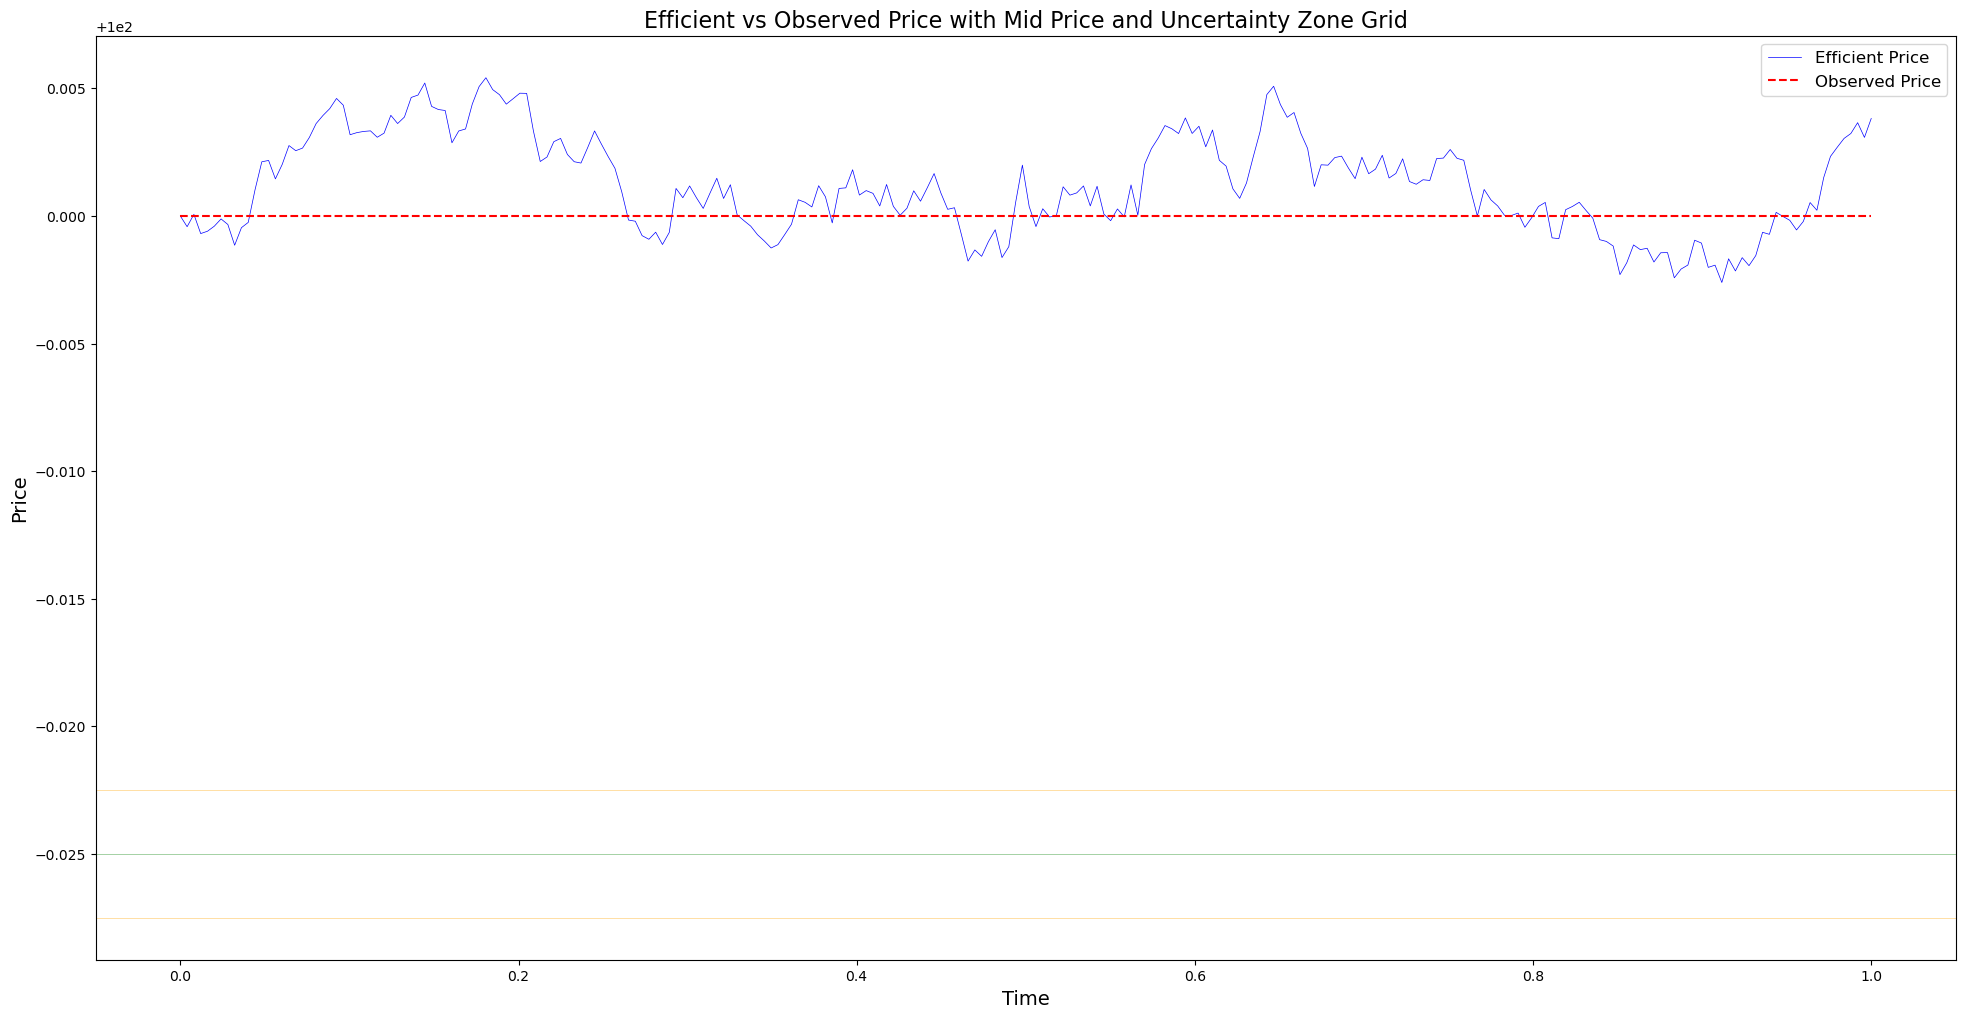

In [6]:
alpha = 0.05      # Tick size
eta = 0.05        # Uncertainty zone width
T = 1.0          # Time horizon
sigma = 0.01   # Volatility, sigma=0.01  5/np.sqrt(252)
X0 = 100.0       # Initial price
n_steps = 250   # Number of time steps
K = 100 # Strike
number_of_paths = 1000 # For Monto Carlo
t, X = simulate_bachelier(T, n_steps, X0, sigma)
plot_uncertainty_zone_matplotlib(X,alpha,eta)

In [7]:
def bachelier_call_and_delta(F0, K, T, sigma_N):
    """
    Bachelier model call option pricing and Delta calculation.
    Returns:
        call_price: Price of the call option
        delta: Delta of the call option
    """
    # 计算 d
    d = (F0 - K) / (sigma_N * np.sqrt(T))

    # 计算 Call Option 价格
    call_price = (F0 - K) * norm.cdf(d) + sigma_N * np.sqrt(T) * norm.pdf(d)

    # 计算 Delta
    delta = norm.cdf(d)

    return call_price, delta

In [8]:
def get_optimal_tau(X, alpha, eta):
    tau = [0]
    l = int(round(alpha**(-0.5)))  # 取最近的整数
    current_zone = (X[0] // alpha) * alpha
    threshold = alpha * (l - 0.5 + eta)
    
    for i in range(1, len(X)):
        upper = current_zone + threshold
        lower = current_zone - threshold
        if X[i] > upper or X[i] < lower:
            tau.append(i)
            current_zone = (X[i] // alpha) * alpha
    return tau

In [9]:
def calculate_hedging_error(t, X, P, tau, K, sigma,use_efficient_price=True):
    """修正后的对冲误差计算函数"""
    T_total = t[-1]
    portfolio = np.zeros(len(tau))
    positions = np.zeros(len(tau))
    calls = np.zeros(len(tau))
    portfolio[0], positions[0] = bachelier_call_and_delta(X[tau[0]], K, T - t[tau[0]],sigma)

    calls[0] = portfolio[0]
    
    # 动态对冲过程
    for j in range(1, len(tau)):
        if use_efficient_price:
            price_change = X[tau[j]] - X[tau[j-1]]
        else:
            price_change = P[tau[j]] - P[tau[j-1]]
        
        # 更新组合价值
        portfolio[j] = portfolio[j-1] + positions[j-1] * price_change
        

        remaining_T = T_total - t[tau[j]]
        calls[j], positions[j] = bachelier_call_and_delta(X[tau[j]], K, remaining_T,sigma)
    
    # 计算最终误差
    #final_payoff = max(X[-1] - K, 0)
    #print(portfolio,positions)
    plt.plot(t[tau], portfolio, label = 'Portfolio value at stopping time')
    plt.plot(t[tau], calls, label = 'Call option price at stopping time')

    #return final_payoff - portfolio[-1]
    return calls[-1]-portfolio[-1]

In [10]:
error_1 = np.zeros(number_of_paths)  
error_2 = np.zeros(number_of_paths) 
error_3 = np.zeros(number_of_paths)

In [11]:
def generate_observed_prices(X, tau, alpha):
    """基于退出时间生成观测价格"""
    P = np.zeros_like(X)
    current_p = None
    for i in range(len(X)):
        if i in tau:
            current_p = np.round(X[i] / alpha) * alpha
        P[i] = current_p if current_p is not None else X[0]
    return P

C:\Users\quyi\AppData\Local\Temp\ipykernel_11884\1389533356.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  d = (F0 - K) / (sigma_N * np.sqrt(T))


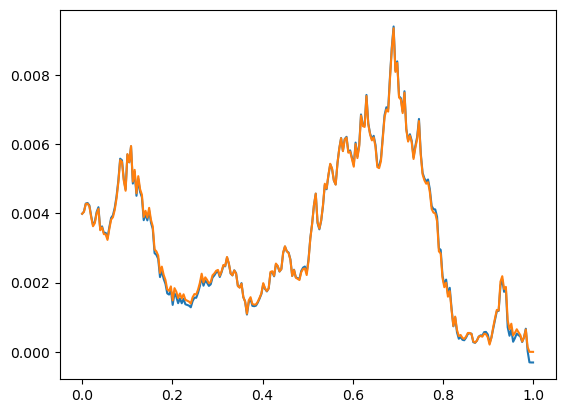

In [12]:
error = np.zeros(1)
for i in range(1):
        t, X = simulate_bachelier(T, n_steps, X0, sigma)
        _, _, P_fixed, tau_fixed = simulate_observed_price(X, alpha, eta,1)
        #P_fixed1, tau_fixed1 = uncertainty_zone_price(X, alpha, eta, 1)

        tau_optimal = get_optimal_tau(X, alpha, eta)
        #print(tau_optimal)
        #print(tau_optimal)
        tau_ideal = list(range(len(t)))  # 所有时间点

        P_optimal = generate_observed_prices(X, tau_optimal, alpha)
        
        error_1[i] = calculate_hedging_error(t, X, X,tau_ideal, K, sigma)
        error_2[i] = calculate_hedging_error(t, X, P_fixed, tau_fixed, K, sigma,False)
        error_3[i] = calculate_hedging_error(t, X, P_optimal, tau_optimal, K, sigma, False)
        #print(len(tau_fixed))

Processing Paths:   0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\quyi\AppData\Local\Temp\ipykernel_11884\1389533356.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  d = (F0 - K) / (sigma_N * np.sqrt(T))
Processing Paths: 100%|██████████| 1000/1000 [01:19<00:00, 12.65it/s]


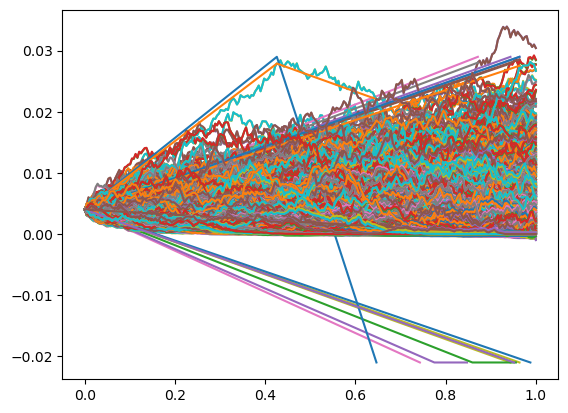

In [13]:
from tqdm import tqdm
for i in tqdm(range(number_of_paths), desc="Processing Paths"):
        t, X = simulate_bachelier(T, n_steps, X0, sigma)
        _, _, P_fixed, tau_fixed = simulate_observed_price(X, alpha, eta)
        tau_optimal = get_optimal_tau(X, alpha, eta)
        tau_ideal = list(range(len(t)))
        P_optimal = generate_observed_prices(X, tau_optimal, alpha)
        
        error_1[i] = calculate_hedging_error(t, X, X, np.arange(len(t)), K, sigma)
        error_2[i] = calculate_hedging_error(t, X, P_fixed, tau_fixed, K, sigma, False)
        error_3[i] = calculate_hedging_error(t, X, P_optimal, tau_optimal, K, sigma, False)

In [14]:
print(error_1.mean())
print(error_2.mean())
print(error_3.mean())
print(error_1.std())
print(error_2.std())
print(error_3.std())

-1.430136223976754e-06
0.00018621550892072126
0.0
0.00022851893226443227
0.0022169562442746946
0.0


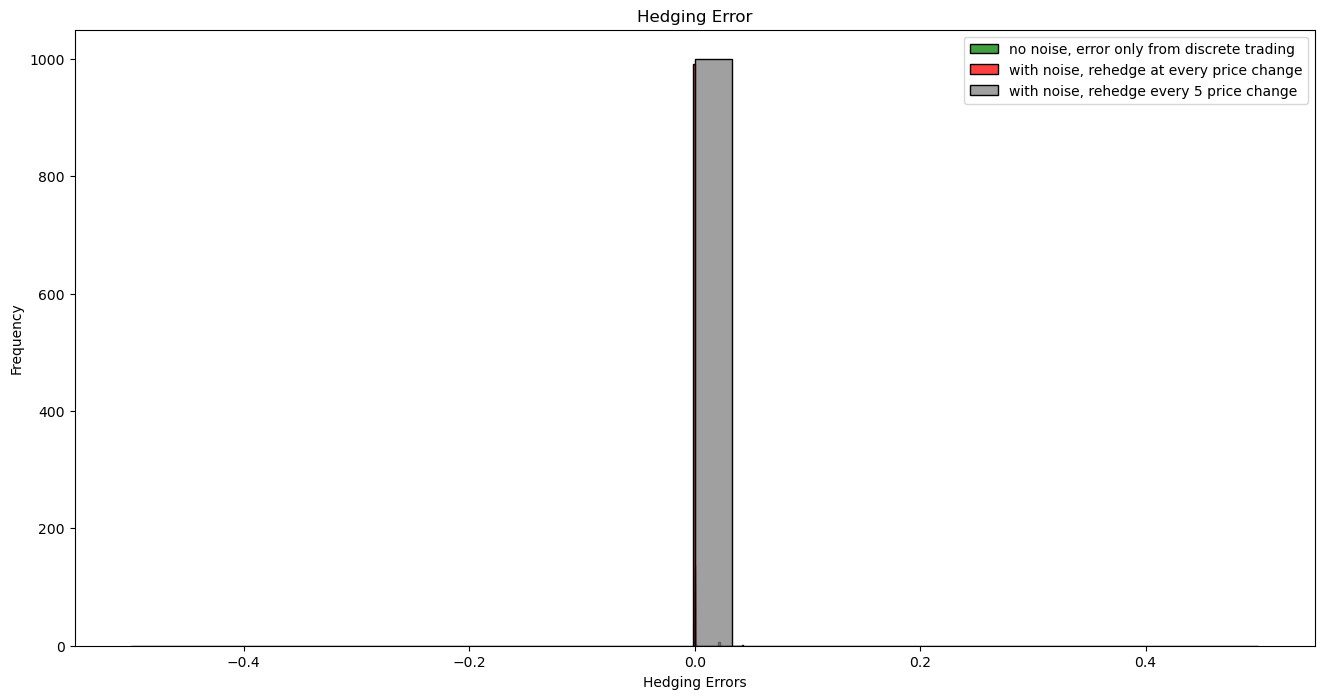

In [15]:
plt.figure(figsize=(16, 8))
sns.histplot(error_1, label = "no noise, error only from discrete trading", bins = 30, color = 'green',stat = 'count',legend=True)
sns.histplot(error_2, label = "with noise, rehedge at every price change", bins = 30, color = 'red',stat = 'count',legend=True)
sns.histplot(error_3, label = f"with noise, rehedge every 5 price change", bins = 30, color='grey',stat = 'count',legend=True)

plt.xlabel("Hedging Errors")
plt.ylabel("Frequency")
plt.title("Hedging Error")
plt.legend()